# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import numpy as np

import torch.utils.data as data

from torch import nn

from src.util.hsi import (
    extract_patches,
    DimReductionType,
    PreProcessType,
    preprocess_hsi,
    train_test_band_patch_split,
    reduce_hsi_dim,
)
from src.model.lenet import FullyConvolutionalLeNet
from src.util.torch import resolve_torch_device
from src.data.indian_pines import load_indian_pines
from src.visualization.plot import plot_segmentation_comparison, plot_epoch_generic
from src.data.dataset_decorator import UnlabeledDatasetDecorator
from src.trainer.co_trainer import BiCoTrainer
from src.model.ensemble import Ensemble
from src.trainer.base_trainer import AdamOptimizedModule
from src.trainer.classification_trainer import ClassificationTrainer
from src.util.reporting import (
    classification_trainer,
    create_model_name,
    report_run,
    read_report_to_show,
)

2. Prepare env

In [2]:
learning_rate = 1e-3
num_epochs = 30
scheduler_step_size = num_epochs
scheduler_gamma = 0.9
weight_decay = 0

In [3]:
batch_size = 33
patch_size = 9
target_dim = 75

pre_process_type = PreProcessType.STANDARTIZATION
dim_reduction_type = DimReductionType.PCA

In [4]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

generator = torch.Generator()
generator.manual_seed(random_seed)

In [5]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [6]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [7]:
_, image = preprocess_hsi(image, pre_process_type)

In [8]:
num_classes = len(np.unique(labels))

f"Number of classes {num_classes}"

'Number of classes 17'

In [9]:
examples_per_class = [20] * num_classes

4. Reduce dimensions

In [10]:
_, target_dim, image = reduce_hsi_dim(
    image, target_dim, dim_reduction_type, device, random_seed
)

5. Prepare dataset

In [11]:
x, y = extract_patches(image, labels, patch_size=patch_size)

In [12]:
x_train, y_train, x_test, y_test, y_masked = train_test_band_patch_split(
    x, y, examples_per_class, "indian_pines"
)

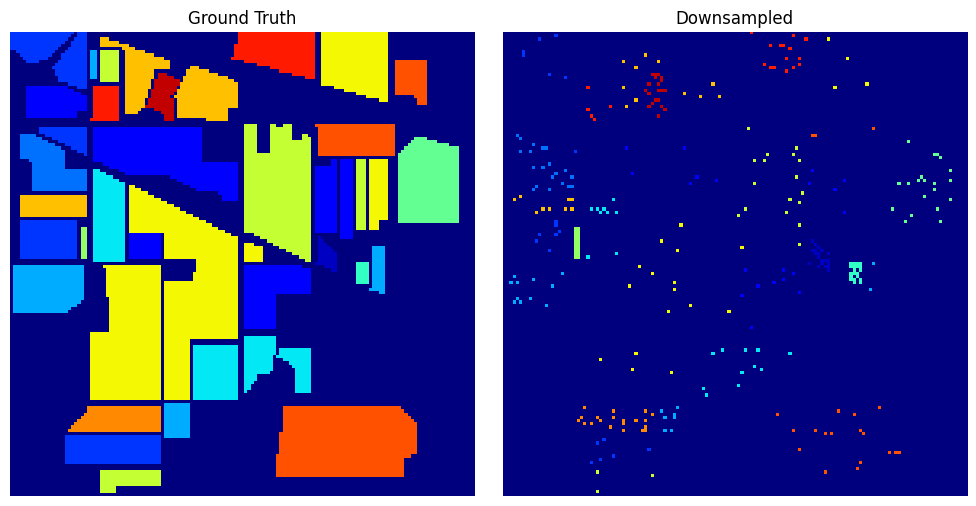

In [13]:
plot_segmentation_comparison(labels, y_masked.reshape(labels.shape), title2="Downsampled")

In [14]:
x_train.shape

(340, 9, 9, 75)

In [15]:
x_all = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2)
y_all = torch.tensor(y, dtype=torch.long)
x_train = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test = torch.tensor(y_test, dtype=torch.long)

In [16]:
train_dataset = data.TensorDataset(x_train, y_train)
test_dataset = data.TensorDataset(x_test, y_test)
full_dataset = data.TensorDataset(x_all, y_all)

In [17]:
train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=generator,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)
full_loader = data.DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)

In [18]:
f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}"

'Training samples: 340, Testing samples: 20685'

6. Train semi-supervised model

In [19]:
model_1 = AdamOptimizedModule(
    FullyConvolutionalLeNet(target_dim, num_classes), 
    lr=learning_rate,
    weight_decay=weight_decay,
    scheduler_step_size=scheduler_step_size,
    scheduler_gamma=scheduler_gamma,
)

model_2 = AdamOptimizedModule(
    FullyConvolutionalLeNet(target_dim, num_classes),
    lr=learning_rate,
    weight_decay=weight_decay,
    scheduler_step_size=scheduler_step_size,
    scheduler_gamma=scheduler_gamma,
)

loss = nn.CrossEntropyLoss()

trainer = ClassificationTrainer(
    num_epochs=num_epochs,
    num_classes=num_classes,
    criterion=loss,
    device=device,
    record_history=False,
    gradient_accumulation_steps=2,
)

co_trainer = BiCoTrainer(
    batch_size=batch_size,
    confidence_threshold=0.9,
    generator=generator,
    trainer=trainer,
)

In [20]:
feedback = co_trainer.fit(
    models=(model_1, model_2),
    labeled=train_dataset,
    unlabeled=test_dataset,
    eval_dl=test_loader,
)

0it [00:00, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [21]:
feedback.history[-1].eval

{'eval_f1': 0.14025886356830597,
 'eval_accuracy_overall': 0.6219061613082886,
 'eval_accuracy_avg': 0.241237610578537,
 'eval_kappa': 0.21380841732025146,
 'eval_loss': 2.8277103900909424}

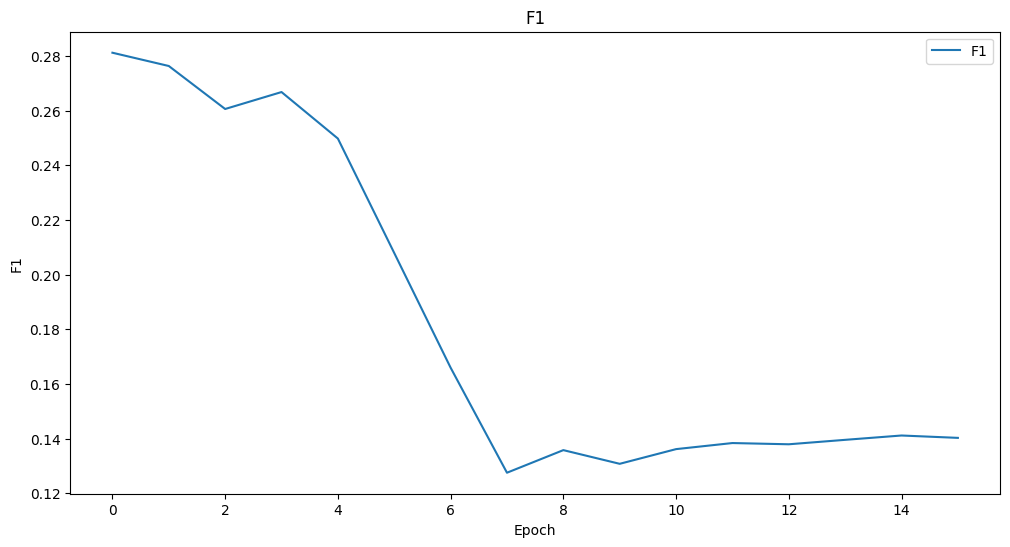

In [22]:
plot_epoch_generic(
    [it.eval["eval_f1"] for it in feedback.history], desc="F1"
)

In [23]:
co_trained = Ensemble([model_1, model_2])

In [24]:
validation_result = trainer.validate(co_trained, full_loader)

validation_result

{'eval_f1': 0.14774996042251587,
 'eval_accuracy_overall': 0.6770635843276978,
 'eval_accuracy_avg': 0.2521759867668152,
 'eval_kappa': 0.22547930479049683,
 'eval_loss': 2.8275206089019775}

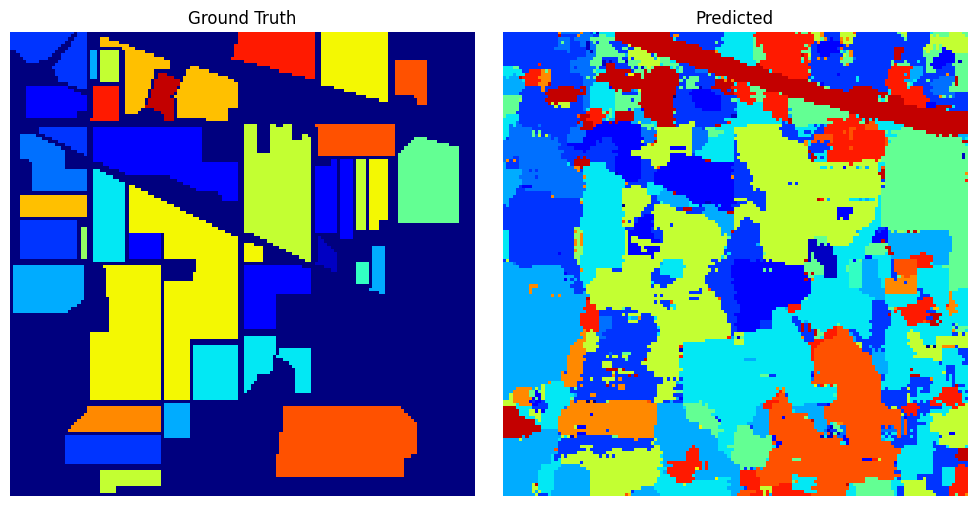

In [25]:
_, y_pred = trainer.predict(co_trained, predict_loader)
y_pred = torch.cat(y_pred, dim=0)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

plot_segmentation_comparison(labels, y_pred.cpu().numpy())

6. Write report

In [26]:
model_name = create_model_name("indian_pines_", examples_per_class)
model_category = "lenet_co_training"

report_run(
    model_name=model_name,
    model_category=model_category,
    run_desc="Less epochs, no scheduling",
    run_params={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "batch_size": batch_size,
        "patch_size": patch_size,
        "target_dim": target_dim,
        "scheduler_step_size": scheduler_step_size,
        "scheduler_gamma": scheduler_gamma,
        "pre_process_type": str(pre_process_type),
        "dim_reduction_type": str(dim_reduction_type),
    },
    run_metrics=classification_trainer(validation_result),
)

PosixPath('/home/melal/Workspace/spatial-regulated-self-training/reports/runs/indian_pines__2020202020202020202020202020202020.csv')

In [29]:
read_report_to_show(model_name, sort_by_metric="OA")

,timestamp,model_category,run_desc,params,loss,f1,OA,AA,kappa
6,2025-05-24T23:39:51.672671+00:00,lenet,"More epochs, PCA and scheduler","{""learning_rate"": 0.001, ""num_epochs"": 300, ""b...",2.497706,0.462771,2.424388e+33,0.457883,NaN
23,2025-05-25T15:52:03.734232+00:00,lenet_co_training,Default run,"{""learning_rate"": 0.001, ""num_epochs"": 300, ""b...",2.826677,0.195459,6.889482e-01,0.286706,0.255198
24,2025-05-25T16:13:53.131416+00:00,lenet_co_training,"Less epochs, no scheduling","{""learning_rate"": 0.001, ""num_epochs"": 30, ""ba...",2.827521,0.147750,6.770636e-01,0.252176,0.225479
22,2025-05-25T14:39:13.847478+00:00,specteal_former_co_training,Default run,"{""hidden_dim"": 32, ""num_layers"": 5, ""num_heads...",2.814270,0.179225,4.305314e-01,0.176266,0.130307
21,2025-05-25T13:49:18.465537+00:00,specteal_former,"With scheduling, incresed dropout and weight d...","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",1.709462,0.629933,3.285941e-01,0.592009,0.428213
19,2025-05-25T13:11:09.295934+00:00,specteal_former,"With scheduling, incresed dropout","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",1.884388,0.610363,3.212764e-01,0.573888,0.418024
17,2025-05-25T12:28:13.957191+00:00,specteal_former,With scheduling,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.039043,0.588829,3.162847e-01,0.557241,0.407733
18,2025-05-25T12:48:49.301608+00:00,specteal_former,"With scheduling, incresed dropout","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.218621,0.575685,3.045633e-01,0.548062,0.399809
16,2025-05-25T11:54:50.924387+00:00,specteal_former,Default run,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.187469,0.560617,2.933610e-01,0.531653,0.385957
8,2025-05-25T00:13:59.916485+00:00,lenet,"A lot more epochs, PCA and scheduler","{""learning_rate"": 0.001, ""num_epochs"": 1000, ""...",2.457449,0.489860,2.897493e-01,0.478478,NaN


In [ ]:
read_report_to_show(model_name, sort_by_metric="OA", model_category=model_category)

,timestamp,run_desc,params,loss,f1,OA,AA,kappa
23,2025-05-25T15:52:03.734232+00:00,Default run,"{""learning_rate"": 0.001, ""num_epochs"": 300, ""b...",2.826677,0.195459,0.688948,0.286706,0.255198
24,2025-05-25T16:13:53.131416+00:00,"Less epochs, no scheduling","{""learning_rate"": 0.001, ""num_epochs"": 30, ""ba...",2.827521,0.147750,0.677064,0.252176,0.225479
